In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import pickle

transactions = pd.read_csv('../database/transactions.csv')

In [69]:
def m_accuracy(model, X, y):
    '''
    returns: the accuracy of the given model, on the digits dataset
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
    clf = model
    clf.fit(X_train, y_train)
    return clf.score(X_test,y_test)

def m_accuracy_mv(model, X, y, N:int):
    '''
    returns: the tupple (mean, std_var)
    '''

    accuracies = [ m_accuracy(model, X, y) for i in range(N) ]
    return (np.mean(accuracies), np.std(accuracies))

def norm2float(df:pd.DataFrame, cols:list):
    for col in cols:
        df[col] = df[col].str.replace(',', '.').astype(float)
        
    return df

In [70]:
# Data Normalization
transactions[['type']] = transactions[['type']].replace(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'], [0, 1, 2, 3, 4])
transactions = transactions.drop(columns=['transactionId', 'nameOrig', 'nameDest'])
transactions = norm2float(transactions, ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])
transactions.head(10)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.00,160296.36,0.0,0.00,0
1,1,3,1864.28,21249.00,19384.72,0.0,0.00,0
2,1,4,181.00,181.00,0.00,0.0,0.00,1
3,1,1,181.00,181.00,0.00,21182.0,0.00,1
4,1,3,11668.14,41554.00,29885.86,0.0,0.00,0
5,1,3,7817.71,53860.00,46042.29,0.0,0.00,0
6,1,3,7107.77,183195.00,176087.23,0.0,0.00,0
7,1,3,7861.64,176087.23,168225.59,0.0,0.00,0
8,1,3,4024.36,2671.00,0.00,0.0,0.00,0
9,1,2,5337.77,41720.00,36382.23,41898.0,40348.79,0


In [74]:
X = transactions.drop(columns=['isFraud'])
y = transactions['isFraud']
smote = SMOTE(random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [75]:
# Model training and testing
N, accuracy = 10, []
df = pd.DataFrame(data=[], columns=['n_neighbors', 'accuracy', 'smote_accuracy'])

for i in range(2, N):
    clf = KNeighborsClassifier(n_neighbors=i)
    smote_clf = KNeighborsClassifier(n_neighbors=i)
    
    clf.fit(X_train, y_train)
    smote_clf.fit(X_train_resampled, y_train_resampled)

    df.loc[len(df)] = [int(i), clf.score(X_test, y_test), smote_clf.score(X_test, y_test)]

df.head(15)

,n_neighbors,accuracy,smote_accuracy
0,2.0,0.997729,0.994391
1,3.0,0.997664,0.991758
2,4.0,0.997773,0.992427
3,5.0,0.997620,0.990181
4,6.0,0.997744,0.990696
5,7.0,0.997585,0.988862
6,8.0,0.997575,0.989372
7,9.0,0.997481,0.987800


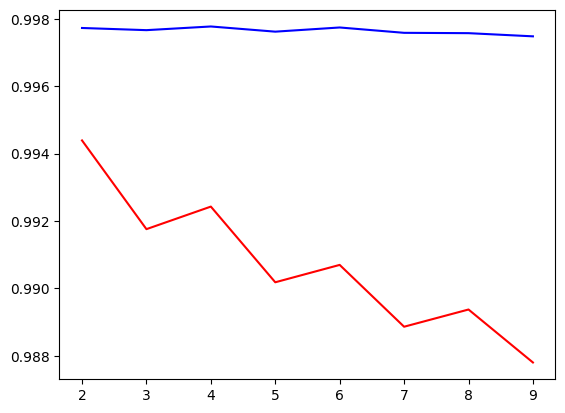

In [77]:
plt.plot(df['n_neighbors'], df['accuracy'], color='blue')
plt.plot(df['n_neighbors'], df['smote_accuracy'], color='red')
plt.show()

In [80]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(X_train, y_train)

pickle.dump(knn_clf, open('./KNN.pkl', 'wb'))